In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "real"
os.environ["PRECISION"] = "single"
os.environ["MY_NUMBA_TARGET"] = "python"

# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [23]:
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation

config = Config(dims=[1], dt = 0.1, mass_real = -1, interaction=0.4)
sim = ComplexLangevinSimulation(config)

In [24]:
from src.obs_kernels import n_moment_kernel, langevin_time
sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_params={'order': 1}, langevin_history=True)
sim.register_observable('langevin_time', obs_kernel=langevin_time, langevin_history=True)

In [27]:
from src.utils import KernelBridge
from src.utils import noise_kernel, evolve_kernel, mexican_hat_kernel_real

kernel_br = KernelBridge(sim, [noise_kernel, evolve_kernel, mexican_hat_kernel_real], const_param={})
n_steps = int(1e4)
phi = np.empty(n_steps)

args = kernel_br.get_current_params()
for k in range(n_steps):
    sim.update_noise(noise_kernel, *args[noise_kernel].values())
    sim.update_drift(mexican_hat_kernel_real, *args[mexican_hat_kernel_real].values())
    args = kernel_br.get_current_params()
    sim.update_field(evolve_kernel, *args[evolve_kernel].values())
    sim.swap()

    sim.compute('1_moment')
    sim.compute('langevin_time')

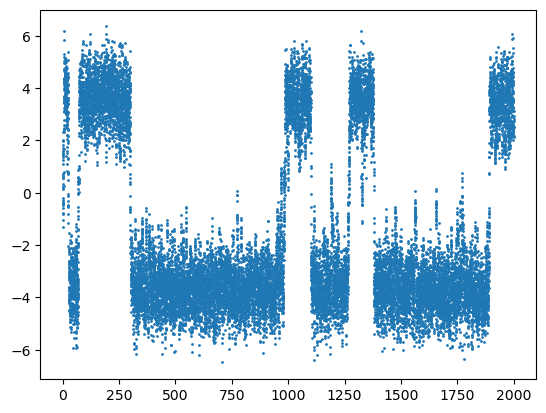

In [28]:
plt.scatter(sim.trackers['langevin_time'].history, sim.trackers['1_moment'].history, s=1)